First, I import the necessary libraries. In this project I will use the CatBoostClassifier classification model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
import re

Upload training dataset

In [2]:
df_train = pd.read_csv("train.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


I study the distribution of data by creating visualizations

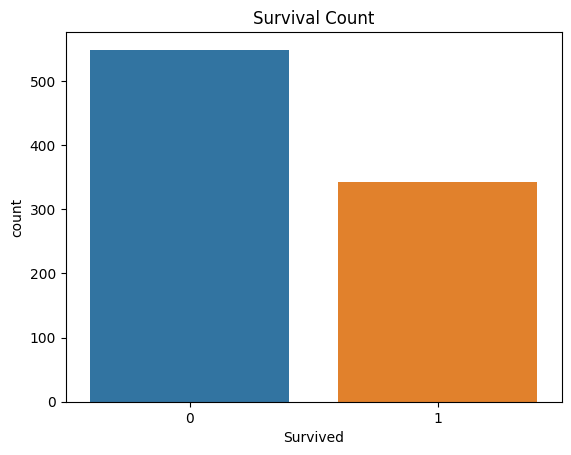

In [4]:
sns.countplot(x='Survived', data=df_train)
plt.title('Survival Count')
plt.show()

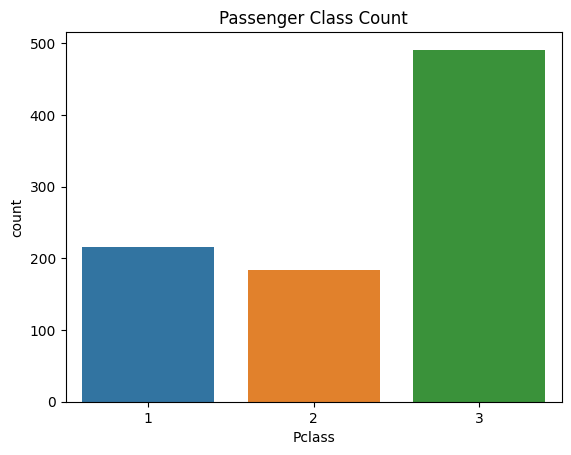

In [5]:
sns.countplot(x='Pclass', data=df_train)
plt.title('Passenger Class Count')
plt.show()

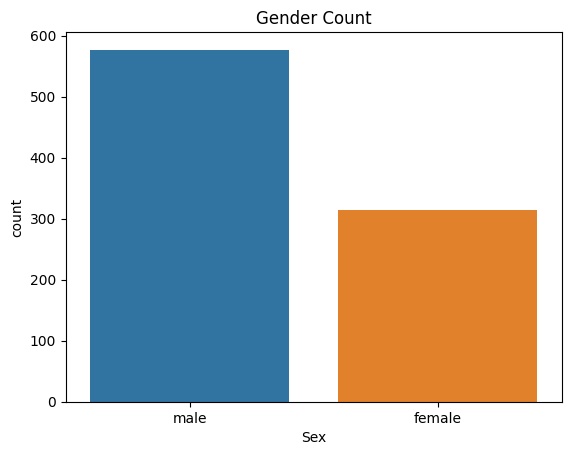

In [6]:
sns.countplot(x='Sex', data=df_train)
plt.title('Gender Count')
plt.show()

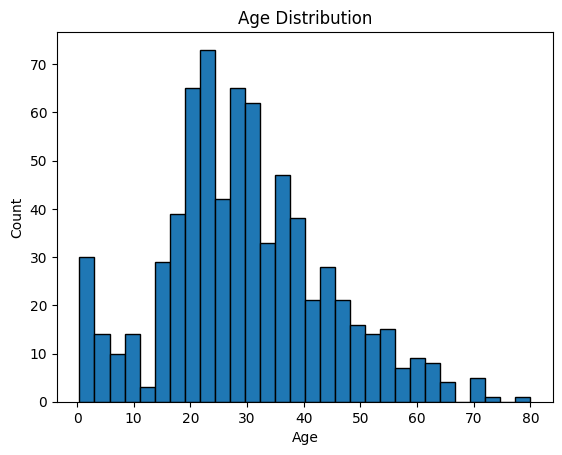

In [7]:
plt.hist(df_train['Age'].dropna(), bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Work with n/a values

I fill in the gaps in the 'Age' column with the median value

I also fill in the gaps in the 'Embarked' column with the mode

In [8]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df_train['Age'].fillna(28, inplace=True)
df_train['Embarked'].fillna('S', inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Feature engineering

Firstly, I extract information from the Name column. You may notice that each name has a title: Mr, Mrs, Dr, etc. Using a regular expression, I extract all the titles and logically combine them into several categories

In [10]:
def substrings(gen_string):
	matches = set()
	regex_pattern = r'[A-Za-z]+\.'
	for string in gen_string:
		matches.add(' '.join(re.findall(regex_pattern, string)).replace('.', ''))
	return matches

titles_train = list(substrings(df_train['Name']))
titles_train

['Sir',
 'Mlle',
 'Capt',
 'Miss',
 'Mrs L',
 'Ms',
 'Countess',
 'Jonkheer',
 'Mr',
 'Mme',
 'Major',
 'Lady',
 'Don',
 'Dr',
 'Master',
 'Col',
 'Mrs',
 'Rev']

In [11]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

df_train['Title']=df_train['Name'].map(lambda x: substrings_in_string(x, titles_train))
df_train['Title'].value_counts()

Title
Mr          641
Miss        182
Master       40
Dr            7
Rev           6
Sir           3
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Ms            1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

After studying the meanings of titles, I decided to distinguish 4 main categories:

1. Mr - here I included the titles Mr, Dr (in case the passenger is a man), as well as other small groups of titles related to men;

2. Miss - since there is a clear division of women into 2 main groups - Miss and Mrs, I decided to leave them and distribute the remained small female title groups into these two categories. Here I included the title Ms (Miss) itself, and also, since the title Miss is given to unmarried women, I included women with the title Mlle (Mademoiselle), which is usually used for young women;

3. Mrs - this title is used in relation to married women, so here, in addition to the title Mrs itself, subjectively, I put the title Countess, Mme (Madame), Lady and Dr (in case the passenger is a woman);

4. Master - Due to the fact that a large number of people have this title, I decided to remain it as a separate category.

In [12]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
df_train['Title']=df_train.apply(replace_titles, axis=1)
df_train['Title'].value_counts()

Title
Mr        657
Miss      185
Master     40
Mrs         9
Name: count, dtype: int64

I summarize the columns SibSp(Siblings + Spouses) and Parch(Parents + Children) on column Family_Size, since I think the effect of these groups of relatives on the target variable is equivalent

In [13]:
df_train['Family_Size']=df_train['SibSp']+df_train['Parch']

The letter at the beginning of the number in the Cabin column obviously means some kind of cabin class and they can be combined by these letters. I extract these letters and group the cabins by them and create a new Cabin_letter column. I replace the missing values with 'unknown' so I can work with them further

In [14]:
df_train['Cabin_Letter'] = df_train['Cabin'].str[:1]
df_train.Cabin_Letter.fillna('Unknown', inplace=True)

Finally, the Ticket column remains. I assume it is possible that some tickets were bought for several passengers at once.

To extract information from the Ticket column, I create a new column that will show the total number of passengers traveling on the same ticket for each passenger

In [15]:
tickets_train = df_train.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets_train.head()

,Count
Ticket,
110152,3
110413,3
110465,2
110564,1
110813,1


In [16]:
df_train['Group_Size']=df_train['Ticket'].apply(lambda x: tickets_train.loc[x, 'Count'])

I delete the Name, Cabin and Ticket columns, since I extracted the necessary information from them and they are no longer needed

In [17]:
df_train.drop(columns=['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,Cabin_Letter,Group_Size
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,1,Unknown,1
1,2,1,1,female,38.0,1,0,71.2833,C,Mr,1,C,1
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,0,Unknown,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mr,1,C,2
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,0,Unknown,1


I separate the data into training features and the target variable

In [18]:
X = df_train.drop(columns=['PassengerId', 'Survived'], axis=1)
y = df_train['Survived']

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

I create an object of the Pool class to train the CatBoostClassifier model

In [20]:
pool = Pool(X, label=y,
                  cat_features=['Sex', 'Embarked', 'Title', 'Cabin_Letter'])

I train the model in the first approximation

In [21]:
model_1 = CatBoostClassifier(learning_rate=0.1, iterations=200, depth=8, eval_metric='AUC:hints=skip_train~false', random_seed=42)
model_1.fit(pool,
				eval_set=(X_val, y_val),
            verbose=False,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
metrics.roc_auc_score(y_val, model_1.predict(X_val))

0.8923423423423423

Using the built-in grid_search function, I search out the optimal global parameters and do cross-validation

In [ ]:
model_2 = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', verbose=False)

grid_params = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
               'iterations': [50, 100, 200, 500, 1000],
					'depth': [2, 4, 6, 8, 10]}


grid_search_result = model_2.grid_search(grid_params,
                                         pool,
                                         verbose=False
                                         )

Print the best parameters

In [24]:
grid_search_result['params']

{'depth': 8, 'iterations': 50, 'learning_rate': 0.3}

Visualize the feature importances for the created model

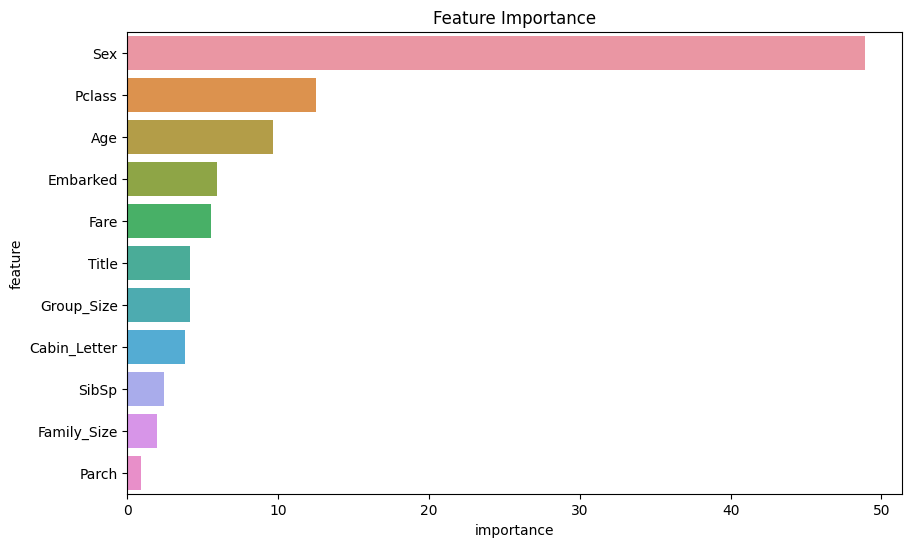

In [25]:
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp',
					 'Parch', 'Fare', 'Embarked', 'Title',
					 'Family_Size', 'Cabin_Letter', 'Group_Size']

importances = model_2.feature_importances_

importances_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='importance', y='feature', orient='h')
plt.title('Feature Importance')
plt.show()

Upload and prepare the test dataset

In [26]:
df_test = pd.read_csv("test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [28]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [29]:
df_test['Age'].fillna(27, inplace=True)
df_test['Fare'].fillna(14.454200, inplace=True)

I call the substrings function to extract titles from the test dataset to find titles that were not in the train dataset, if any

In [30]:
titles_test = list(substrings(df_test['Name']))
[item for item in titles_test if item not in set(titles_train)]

['Dona']

In [31]:
df_test['Title']=df_test['Name'].map(lambda x: substrings_in_string(x, titles_test))
df_test['Title'].value_counts()

Title
Mr        311
Miss       78
Master     20
Col         2
Rev         2
Dr          2
Dona        2
Ms          1
Name: count, dtype: int64

According to the information I found, Dona is a title that is given to the wives of nobles, therefore, I will put it in the group of titles Mrs

In [32]:
def replace_titles_test(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
df_test['Title']=df_test.apply(replace_titles_test, axis=1)
df_test['Title'].value_counts()

Title
Mr        315
Miss       79
Master     20
Mrs         4
Name: count, dtype: int64

In [33]:
df_test['Family_Size']=df_test['SibSp']+df_test['Parch']

In [34]:
df_test['Cabin_Letter'] = df_test['Cabin'].str[:1]
df_test.Cabin_Letter.fillna('Unknown', inplace=True)

In [35]:
df_test['Cabin_Letter'].value_counts()

Cabin_Letter
Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: count, dtype: int64

In [36]:
tickets_test = df_test.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets_test.head()

,Count
Ticket,
110469,1
110489,1
110813,1
111163,1
112051,1


In [37]:
df_test['Group_Size']=df_test['Ticket'].apply(lambda x: tickets_test.loc[x, 'Count'])

In [38]:
df_test.drop(columns=['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,Cabin_Letter,Group_Size
0,892,3,male,34.5,0,0,7.8292,Q,Mr,0,Unknown,1
1,893,3,female,47.0,1,0,7.0000,S,Mr,1,Unknown,1
2,894,2,male,62.0,0,0,9.6875,Q,Mr,0,Unknown,1
3,895,3,male,27.0,0,0,8.6625,S,Mr,0,Unknown,1
4,896,3,female,22.0,1,1,12.2875,S,Mr,2,Unknown,1


Make a prediction and send it to Kaggle.com

In [39]:
df_test['Survived'] = model_2.predict(df_test.drop(columns='PassengerId', axis=1))
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,Cabin_Letter,Group_Size,Survived
0,892,3,male,34.5,0,0,7.8292,Q,Mr,0,Unknown,1,0
1,893,3,female,47.0,1,0,7.0000,S,Mr,1,Unknown,1,0
2,894,2,male,62.0,0,0,9.6875,Q,Mr,0,Unknown,1,0
3,895,3,male,27.0,0,0,8.6625,S,Mr,0,Unknown,1,0
4,896,3,female,22.0,1,1,12.2875,S,Mr,2,Unknown,1,0


In [40]:
df_test['Survived'].value_counts()

Survived
0    269
1    149
Name: count, dtype: int64

In [41]:
submission = df_test[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)

Score = 0.77511